In [ ]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

11490434/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


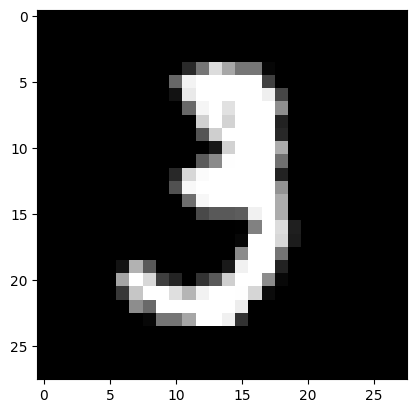

In [ ]:
# plot raw pixel data
import matplotlib.pyplot as plt
plt.imshow(trainX[10], cmap='gray')

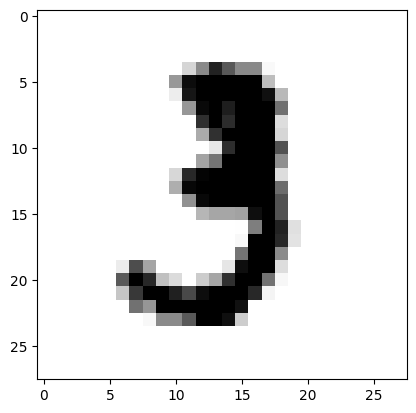

In [ ]:
plt.imshow(trainX[10], cmap='gray_r')

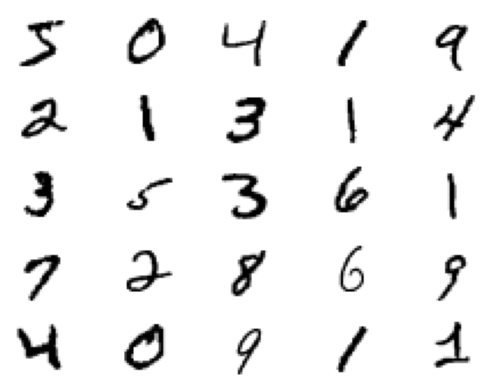

In [ ]:
# plot images from the training dataset
for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)                                                                                        #mat
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

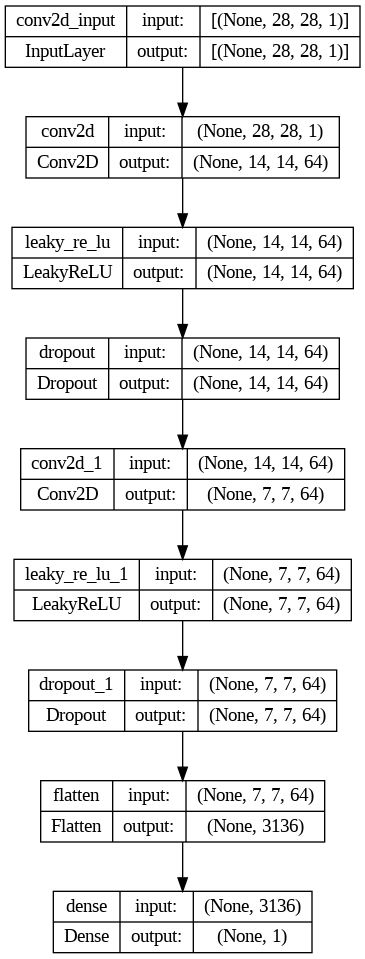

In [ ]:
# define the standalone discriminator model
import keras
from keras import layers
from keras.optimizers import Adam
from keras.utils import plot_model
def define_discriminator(in_shape=(28,28,1)):
	model = keras.Sequential()
	model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Dropout(0.4))
	model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Dropout(0.4))
	model.add(layers.Flatten())
	model.add(layers.Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# load and prepare mnist training images
import numpy as np
from numpy import expand_dims
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

In [ ]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = np.random.rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
# define the standalone generator model
def define_generator(latent_dim=100):
	model = keras.Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(layers.Dense(n_nodes, input_dim=latent_dim))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                           

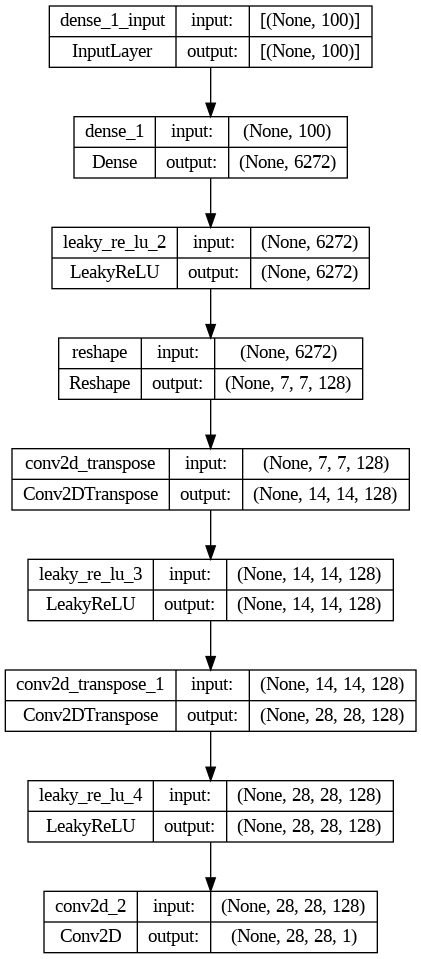

In [ ]:
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

1/1 [==============================] - 1s 550ms/step


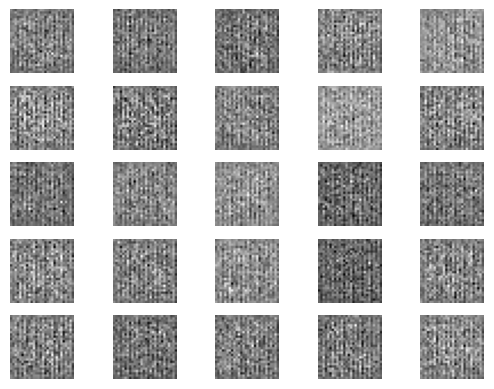

In [ ]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
 # define subplot
 plt.subplot(5, 5, 1 + i)
 # turn off axis labels
 plt.axis('off')
 # plot single image
 plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = keras.Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1204994 (4.60 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 40705 (159.00 KB)
_________________________________________________________________


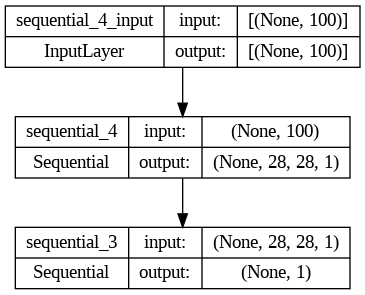

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# create and save a plot of generated images (reversed grayscale)
from matplotlib import pyplot
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [ ]:
# train the generator and discriminator
from numpy import ones,vstack
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [ ]:
latent_dim=100
d_model=define_discriminator()
g_model=define_generator()
gan_model=define_gan(g_model,d_model)
dataset = load_real_samples()
train(dataset=dataset,g_model=g_model,d_model=d_model,gan_model=gan_model,n_epochs=100,latent_dim=latent_dim,n_batch=256)

4/4 [==============================] - 2s 367ms/step
>1, 1/234, d=0.686, g=0.816
4/4 [==============================] - 1s 273ms/step
>1, 2/234, d=0.650, g=0.913
4/4 [==============================] - 1s 244ms/step
>1, 3/234, d=0.617, g=0.970
4/4 [==============================] - 1s 154ms/step
>1, 4/234, d=0.620, g=0.901
4/4 [==============================] - 1s 152ms/step
>1, 5/234, d=0.647, g=0.759
4/4 [==============================] - 1s 155ms/step
>1, 6/234, d=0.627, g=0.705
4/4 [==============================] - 1s 150ms/step
>1, 7/234, d=0.595, g=0.697
4/4 [==============================] - 1s 153ms/step
>1, 8/234, d=0.544, g=0.700
4/4 [==============================] - 1s 150ms/step
>1, 9/234, d=0.496, g=0.706
4/4 [==============================] - 1s 155ms/step
>1, 10/234, d=0.452, g=0.713
4/4 [==============================] - 1s 241ms/step
>1, 11/234, d=0.414, g=0.720
4/4 [==============================] - 1s 164ms/step
>1, 12/234, d=0.385, g=0.731
4/4 [====================